In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import math
import unicodedata
import re
import gc
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import CustomBert
from CustomBert import CustomBertForMaskedLM
from CustomBert import CustomBertConfig
from WordPieceTokenizer import WordPieceTokenizer as Tokenizer
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from PretrainDataset import TokenizedDataset
from PretrainDataset import CustomDataCollatorForMLM

In [2]:
def group_texts(examples, tokenizer, MAX_SEQUENCE_LENGTH):
    concatenated_text = " ".join(examples["text"])

    encoded_output = tokenizer.encode(
        concatenated_text,
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding=True,
        add_special_tokens=True
    )
    
    return {
        "input_ids": [torch.tensor(encoded_output['input_ids'], dtype=torch.long)],
        "attention_mask": [torch.tensor(encoded_output['attention_mask'], dtype=torch.long)],
        "token_type_ids": [torch.tensor(encoded_output['token_type_ids'], dtype=torch.long)],
    }

In [3]:
tokenizer = Tokenizer(vocab_file_path="saves/vocab.txt",do_lower_case=False,strip_accents=False,clean_text=True)
VOCAB_SIZE = tokenizer.get_vocab_size()
MAX_SEQUENCE_LENGTH = 128
BATCH_SIZE = 32

datasetsPath = 'datasets/'
PREPROCESSED_TEXT_DIR = f'{datasetsPath}preprocess_wiki_text'

text_files = [os.path.join(PREPROCESSED_TEXT_DIR, f) for f in os.listdir(PREPROCESSED_TEXT_DIR) if f.endswith('.txt')]

if not text_files:
    exit()
print(f'총 {len(text_files)}개의 텍스트 파일 로드 시작...')
raw_dataset = load_dataset("text", data_files={"train": text_files}, split="train")
print(f"원시 데이터셋 로드 완료. 총 {len(raw_dataset)}개의 샘플.")
    
print('데이터셋 토큰화 및 청킹 시작...')
tokenized_dataset = raw_dataset.map(
    group_texts,
    batched=True,
    num_proc=1,
    remove_columns=["text"],
    fn_kwargs={"tokenizer":tokenizer,"MAX_SEQUENCE_LENGTH":MAX_SEQUENCE_LENGTH},
    desc=f"맵핑 데이터셋 (토큰화 및 청킹, 최대 길이 {MAX_SEQUENCE_LENGTH})"
)
print(len(tokenized_dataset))

총 8개의 텍스트 파일 로드 시작...
원시 데이터셋 로드 완료. 총 702964개의 샘플.
데이터셋 토큰화 및 청킹 시작...
703


In [4]:
print("토큰화된 데이터셋 저장 중...")
tokenized_dataset_path = "datasets/tokenized_dataset"
tokenized_dataset.save_to_disk(tokenized_dataset_path)
print(f"토큰화된 데이터셋이 '{tokenized_dataset_path}'에 저장되었습니다.")

토큰화된 데이터셋 저장 중...


Saving the dataset (0/1 shards):   0%|          | 0/703 [00:00<?, ? examples/s]

토큰화된 데이터셋이 'datasets/tokenized_dataset'에 저장되었습니다.


In [5]:
train_dataset = TokenizedDataset(tokenized_dataset)

data_collator = CustomDataCollatorForMLM(tokenizer=tokenizer, mlm_probability=0.15)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=os.cpu_count()
)

print(f"PyTorch DataLoader 생성 완료. 배치 크기: {BATCH_SIZE}")
print(f"총 훈련 배치 수: {len(train_dataloader)}")

PyTorch DataLoader 생성 완료. 배치 크기: 32
총 훈련 배치 수: 22


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_SAVE_PATH = "saves/Pretrain.pt"

HIDDEN_SIZE = 768
NUM_HIDDEN_LAYERS = 12
NUM_ATTENTION_HEADS = 12
INTERMEDIATE_SIZE = 3072
TYPE_VOCAB_SIZE = 2
DROPOUT_PROB = 0.1

config = CustomBertConfig(
    VOCAB_SIZE=VOCAB_SIZE,
    HIDDEN_SIZE=HIDDEN_SIZE,
    NUM_HIDDEN_LAYERS=NUM_HIDDEN_LAYERS,
    NUM_ATTENTION_HEADS=NUM_ATTENTION_HEADS,
    INTERMEDIATE_SIZE=INTERMEDIATE_SIZE,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH,
    TYPE_VOCAB_SIZE=TYPE_VOCAB_SIZE,
    DROPOUT_PROB=DROPOUT_PROB
)

model = CustomBertForMaskedLM(config)

if os.path.exists(MODEL_SAVE_PATH):
    print("모델 가중치 로드 중...")
    # 먼저 CPU에 로드한 후 모델에 로드합니다.
    loaded_state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu')
    model.load_state_dict(loaded_state_dict)
    print("모델 가중치 로드 완료.")
else:
    print("새로운 모델 초기화 완료. 저장된 가중치를 찾을 수 없습니다.")

model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Custom Bert 모델 초기화 완료. 총 학습 가능 파라미터 수 : {num_params}')
print(f'모델이 담긴 장치 : {device}')

모델 가중치 로드 중...
모델 가중치 로드 완료.
Custom Bert 모델 초기화 완료. 총 학습 가능 파라미터 수 : 110946560
모델이 담긴 장치 : cuda


In [10]:
EPOCHS = 20
LEARNING_RATE = 5e-8
WEIGHT_DECAY = 0.1
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_dataloader) * EPOCHS
WARMUP_STEPS = int(total_steps * 0.05)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,num_training_steps=total_steps)
print(f"총 학습 스텝 수: {total_steps}")
print(f"워밍업 스텝 수: {WARMUP_STEPS}")

총 학습 스텝 수: 440
워밍업 스텝 수: 22


In [10]:
LOSS_PATH = f"saves/Pretrain_loss.txt"

if os.path.exists(LOSS_PATH):
    with open(LOSS_PATH,'r') as f:
        content = f.read()
        if content.strip():
            prev_loss = float(content.strip())
else:
    prev_loss = 10

train_losses = []
scaler = torch.cuda.amp.GradScaler()

print(f"\n<--- 학습 시작 ---> ({EPOCHS} 에폭)")
model.train()

for e in range(EPOCHS):
    loss_sum = 0
    progress_bar = tqdm(train_dataloader, desc=f"Pre-train Epoch {e+1}")

    for step, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            labels=batch["labels"]
        )
        loss = outputs["loss"]

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        optimizer.step()

        scheduler.step()
        optimizer.zero_grad()

        loss_sum += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        del outputs, loss
        if 'cuda' in str(device):
            torch.cuda.empty_cache()
        gc.collect()

    avg_train_loss = loss_sum / len(train_dataloader)
    train_losses.append(avg_train_loss)

    print(f"Pre-train Epoch {e+1} 완료. 평균 학습 손실: {avg_train_loss:.4f}")

    if avg_train_loss < prev_loss - 0.0001:
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        prev_loss = avg_train_loss
        print(f"모델 가중치 '{MODEL_SAVE_PATH}' 저장 완료.")
        with open(LOSS_PATH,'w') as f:
            f.write(str(avg_train_loss))
            print(f"모델 평균 손실률 '{LOSS_PATH}' 저장 완료.")

print("\n<--- 학습 완료 --->")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15300\26981965.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



<--- 학습 시작 ---> (20 에폭)



KeyboardInterrupt


KeyboardInterrupt



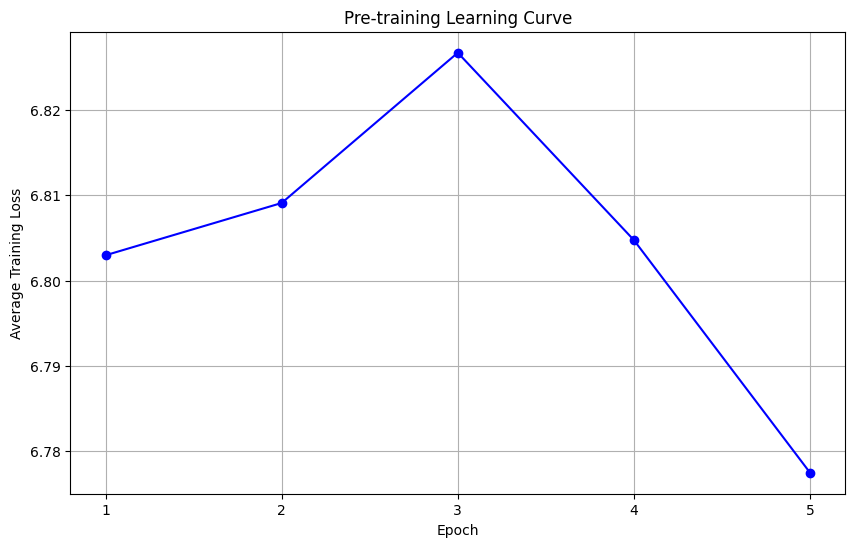

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Pre-training Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1)) # x축 눈금 에폭 수에 맞춰 표시
plt.show()